**************************************************INITIALIZATION*********************************************************

In [1]:
from tjmonopix.tjmonopix import TJMonoPix
import time

chip = TJMonoPix()
chip['CONF']['DEF_CONF_N'] = 0
chip['CONF'].write()
chip.init()
chip.power_on()

chip['CONF']['RESET_BCID'] = 1
chip['CONF']['RESET'] = 1
chip['CONF'].write()

chip['CONF']['EN_BX_CLK'] = 1
chip['CONF']['EN_OUT_CLK'] = 1
chip['CONF'].write()
 
chip['CONF']['RESET_BCID'] = 0
chip['CONF']['RESET'] = 0
chip['CONF'].write()

chip.default_conf()

#-------------------------------------------------#
chip['CONF_SR']['SET_ICASN'].setall(False)
chip['CONF_SR']['SET_ICASN'][68:62] = True

chip['CONF_SR']['SET_VRESET_P'].setall(False)
chip['CONF_SR']['SET_VRESET_P'][35] = 1 #1V

chip['CONF_SR']['SET_IRESET'].setall(False)
chip['CONF_SR']['SET_IRESET'][86:42] = True #1.5nA

chip['CONF_SR']['SET_ITHR'].setall(False)
chip['CONF_SR']['SET_ITHR'][71:56] = True #2.1nA

chip['CONF_SR']['EN_HV'].setall(False)
chip['CONF_SR']['EN_COMP'].setall(False)
chip['CONF_SR']['EN_PMOS'].setall(True)
chip['CONF_SR']['EN_PMOS_NOSF'].setall(False)
chip['CONF_SR']['EN_TEST_PATTERN'].setall(False)

chip['CONF_SR']['MASKD'].setall(False)
chip['CONF_SR']['MASKH'].setall(False)
chip['CONF_SR']['MASKV'].setall(False)

chip.write_conf()

chip['CONF']['DEF_CONF_N'] = 1
chip['CONF'].write()

2018-02-22 22:52:31,977 - [root           ] - ERROR   'NoneType' object has no attribute 'WriteExternal'
2018-02-22 22:52:32,007 - [root           ] - INFO    Found USB board(s): USBpix with ID 207 (FW 15)
2018-02-22 22:52:32,010 - [root           ] - INFO    Programming FPGA: tjmonopix_mio.bit...
2018-02-22 22:52:39,948 - [root           ] - INFO    Success!
2018-02-22 22:52:40,368 - [root           ] - INFO    Found adapter card: General Purpose Analog Card with ID 1
2018-02-22 22:52:40,391 - [root           ] - INFO    Initializing fifo (firmware version: 2), module basil.HL.sram_fifo, base_addr 0x18000
2018-02-22 22:52:40,393 - [root           ] - INFO    Initializing gpio (firmware version: 0), module basil.HL.gpio, base_addr 0x10000
2018-02-22 22:52:40,396 - [root           ] - INFO    Initializing spi (firmware version: 2), module basil.HL.spi, base_addr 0x11000
2018-02-22 22:52:40,399 - [root           ] - INFO    Initializing inj (firmware version: 3), module basil.HL.pulse_ge

4098


****************************************************POWER_STATUS*********************************************************

In [325]:
chip.get_power_status()

{'VDDA [V]': 1.7925618542914172,
 'VDDA [mA]': 56.89565359716501,
 'VDDA_DAC [V]': 1.798314513944223,
 'VDDA_DAC [mA]': 3.53162464064632,
 'VDDD [V]': 1.799759839679359,
 'VDDD [mA]': -3.3934469967968035e-08,
 'VDDP [V]': 1.7947520410410414,
 'VDDP [mA]': 154.30144185899968}

****************************ENABLE_COLUMS, SET MASKS, SELECT WHICH COLUMN AND ROW TO INJECT******************************

In [326]:
# SELECT WHICH DOUBLE COLUMNS TO ENABLE
chip['CONF_SR']['EN_PMOS_NOSF'].setall(False)
chip['CONF_SR']['EN_PMOS'].setall(False)
chip['CONF_SR']['EN_COMP'].setall(False)
chip['CONF_SR']['EN_HV'].setall(False)
chip['CONF_SR']['EN_OUT'].setall(False) #ENABLES OR DISABLES THE NORMAL OUTPUT PADS
chip['CONF_SR']['nEN_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY OUTPUT PADS

chip['CONF_SR']['EN_PMOS'][9] = 1

# SELECT WHICH PHYSICAL COLUMNS, ROWS, DIAGONALS TO MASK
chip['CONF_SR']['MASKD'].setall(False)
chip['CONF_SR']['MASKH'].setall(False)
chip['CONF_SR']['MASKV'].setall(False)
chip['CONF_SR']['MASKH'][99] = True

# SELECT WHICH PHYSICAL COLUMS TO INJECT
# INJ_IN_MON_L AND INJ_IN_MON_L SELECT THE LEFT AND RIGHT SPECIAL ANALOG MONITORING PIXELS
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)
chip['CONF_SR']['COL_PULSE_SEL'][130] = 1
chip['CONF_SR']['INJ_IN_MON_L'] = 1
chip['CONF_SR']['INJ_IN_MON_R'] = 0

# SELECT WHICH ROWS TO INJECT
# THE SPEXIAL PIXELS OUTA_MON3 to OUTA_MON0 CORRESPONT TO ROWS 223 to 220 FOR INJECTION
chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['INJ_ROW'][99] = 1
chip['CONF_SR']['INJ_ROW'][223:220] = True

chip.write_conf()

******************INITIALIZE COMMUNICATION, RECEIVE DATA (CHECK IF DATA ARE SENT WITH EACH EXCECUTION)*******************

In [328]:
chip['data_rx'].set_en(True)

x = chip['fifo'].get_data()

ix = chip.interprete_data(x)
print(ix)

# ix = chip.interprete_raw_data(x)
# print(ix)

[]


************CONFIGURE THE FRONT END CURRENT AND VOLTAGE BIASES, CONFIGURE THE HEIGHT OF THE INJECTION PULSE**************

In [415]:
# SET THE INJECTION PULSE AMPLITUDE
# The default values are VL=44, VH=79, VH-VL=35
# VDAC LSB=14.17mV, Cinj=230aF, 1.43e-/mV, ~710e-
chip['CONF_SR']['SET_VL'].setall(False)
chip['CONF_SR']['SET_VL'][44] = 1
chip['CONF_SR']['SET_VH'].setall(False)
chip['CONF_SR']['SET_VH'][79] = 1

####### CONFIGURE THE FRONT END ######

# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT
chip['CONF_SR']['SET_VRESET_P'].setall(False)
chip['CONF_SR']['SET_VRESET_P'][35] = 1 #1V

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
chip['CONF_SR']['SET_ICASN'].setall(False)
chip['CONF_SR']['SET_ICASN'][65:55] = True # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
chip['CONF_SR']['SET_IRESET'].setall(False)
chip['CONF_SR']['SET_IRESET'][65:57] = True #270pA

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
chip['CONF_SR']['SET_ITHR'].setall(False)
chip['CONF_SR']['SET_ITHR'][60:56] = True #680pA

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
chip['CONF_SR']['SET_IDB'].setall(False)
chip['CONF_SR']['SET_IDB'][78:50] = True #500nA

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
chip['CONF_SR']['SET_IBIAS'].setall(False)
chip['CONF_SR']['SET_IBIAS'][82:41] = True #500nA

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()

****************************SET THE INJECTION PULSE PARAMETERS, INJECT x times and get the data**************************

In [419]:
#chip['inj'].reset()
chip['inj'].set_delay(100)
chip['inj'].set_width(80)
chip['inj'].set_repeat(1)
chip['inj'].set_en(0)

while not chip['inj'].is_ready:
    time.sleep(0.001)

for _ in range(10):
    chip['inj'].is_ready

chip["inj"].start()

x = chip['fifo'].get_data()

ix = chip.interprete_data(x)
print(ix)

#ix = chip.interprete_raw_data(x)
#print(ix)

[(18, 99, 14, 39, 0)]


**********************************MAKE AN INJECTION SCAN -  S-CURVE OF ONE PIXEL*****************************************

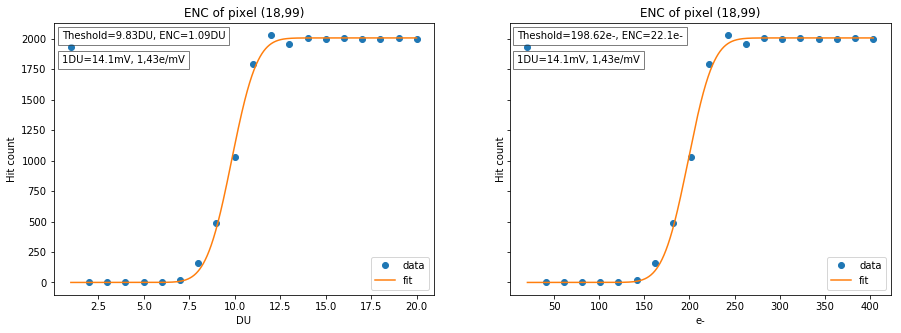

In [421]:
import matplotlib.pyplot as plt
%matplotlib inline
hits = []
xhits = []
from scipy.optimize import curve_fit
from scipy.special import erf
import numpy as np

def scurve(x, A, mu, sigma):
    return 0.5 * A * erf((x - mu) / (np.sqrt(2) * sigma)) + 0.5 * A

class pixel:
    def __init__(self, col, row):
        self.col = col
        self.row = row
    
pix = pixel(col=18, row=99)
start_dif=1
repeat=2000
VL=40
VH_max=60
        
###########################################################################
chip['CONF_SR']['SET_VL'].setall(False)
chip['CONF_SR']['SET_VL'][VL] = 1

for i in range(start_dif,VH_max-VL+1):
    chip['CONF_SR']['SET_VH'].setall(False)
    chip['CONF_SR']['SET_VH'][VL+i] = 1

    chip.write_conf()
    time.sleep(0.01)
    
    chip['inj'].set_delay(100)
    chip['inj'].set_width(80)
    chip['inj'].set_repeat(repeat)
    chip['inj'].set_en(0)
    
    while not chip['inj'].is_ready:
        time.sleep(0.001)

    for _ in range(10):
        chip['inj'].is_ready
        
    chip["inj"].start()
    
    x = chip['fifo'].get_data()

    ix = chip.interprete_data(x)
    
    #print(ix)
    
    cnt = 0
    for hit in ix:
        if hit['col'] == pix.col and  hit['row'] == pix.row:
            cnt += 1
            
    hits.append(cnt)
    xhits.append(i)
    
###########################################################################
#print hits

max_occ = repeat
threshold = (VH_max-VL)/2

popt, _ = curve_fit(scurve, xhits, hits, p0=[max_occ, threshold, 50.], check_finite=False)
#print popt

newx = np.arange(start_dif,VH_max-VL,0.01)
fit = scurve(np.arange(start_dif,VH_max-VL,0.01), *popt)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
ax1.plot(xhits, hits, 'o', label='data')
ax1.plot(newx, fit, label='fit')
ax1.set(xlabel='DU', ylabel='Hit count',title=('ENC of pixel (' +str(pix.col) +',' +str(pix.row) +')'))
ax1.legend(loc='best')
ax1.text(0.5, repeat*1, ('Theshold=' +str(round(popt[1],2)) +'DU, ENC=' +str(round(popt[2],2)) +'DU'), bbox=dict(facecolor='white', alpha=0.5))
ax1.text(0.5, repeat*0.9, "1DU=14.1mV, 1,43e/mV", bbox=dict(facecolor='white', alpha=0.5))

hite = np.array(xhits)
hite = hite*20.2

popt, _ = curve_fit(scurve, hite, hits, p0=[max_occ, threshold*20.2, 400.], check_finite=False)
#print popt

newxe = np.arange(start_dif*20.2,(VH_max-VL)*20.2,0.01)
fite = scurve(np.arange(start_dif*20.2,(VH_max-VL)*20.2,0.01), *popt)

ax2.plot(hite, hits, 'o', label='data')
ax2.plot(newxe, fite, label='fit')
ax2.set(xlabel='e-', ylabel='Hit count',title=('ENC of pixel (' +str(pix.col) +',' +str(pix.row) +')'))
ax2.legend(loc='best')
ax2.text(9, repeat*1, ('Theshold=' +str(round(popt[1],2)) +'e-, ENC=' +str(round(popt[2],2)) +'e-'), bbox=dict(facecolor='white', alpha=0.5))
ax2.text(9, repeat*0.9, "1DU=14.1mV, 1,43e/mV", bbox=dict(facecolor='white', alpha=0.5))
fig.savefig('/faust/user/kmoustakas/ENC')